In [1]:
%config Completer.use_jedi = False

In [2]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
root = Path("Task02_Heart/imagesTr/")
label = Path("Task02_Heart/labelsTr/")

In [4]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [5]:
sample_path = list(root.glob("la*"))[0]
sample_path_label = change_img_to_label_path(sample_path)

In [6]:
sample_path, sample_path_label

(PosixPath('Task02_Heart/imagesTr/la_003.nii.gz'),
 PosixPath('Task02_Heart/labelsTr/la_003.nii.gz'))

In [7]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [8]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [9]:
from celluloid import Camera
from IPython.display import HTML

<IPython.core.display.Javascript object>


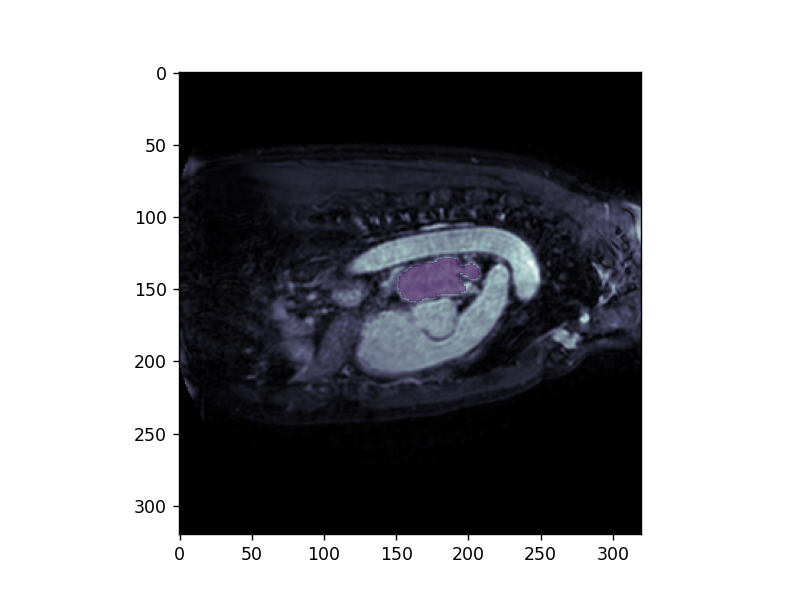

In [10]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5)
    camera.snap()
animation = camera.animate()

In [11]:
HTML(animation.to_html5_video())

/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


In [12]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [13]:
all_files = list(root.glob("la*"))
len(all_files)

20

In [14]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    normalizeed_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalizeed_mri_data)
    
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
        
    for i in range(standardized_mri_data.shape[-1]):
        slices = standardized_mri_data[:, :, i]
        mask = label_data[:, :, i]
        slice_path = current_path/"data"
        mask_path = current_path/"mask"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slices)
        np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
path = Path("Preprocessed/train/0")
file = "100.npy"

In [52]:
slices = np.load(path/"data"/file)
mask = np.load(path/"mask"/file)

<IPython.core.display.Javascript object>


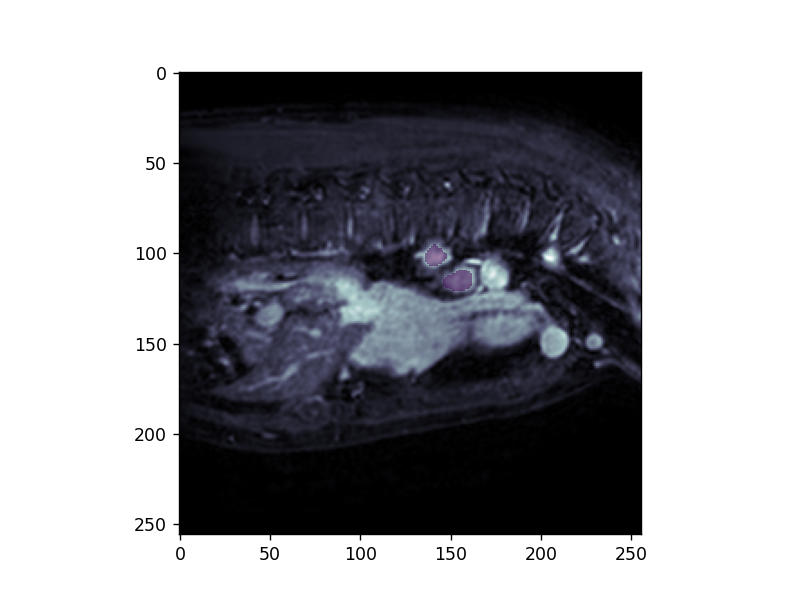

In [59]:
plt.figure()
plt.imshow(slices, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, alpha=0.5)